# Introduction to Spark

## Basic initialization

`SparkSession` is used to connect to the Spark Cluster.

In [1]:
from pyspark.sql import SparkSession

We will use Pandas to operate on the reduced data in the *driver program*.

In [2]:
import pandas as pd

Numpy will be always useful.

In [3]:
import numpy as np

Create a new session (or reuse an existing one).

In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
print(spark)

We can see that the session is established.

## Using basic operations on RDD

Obtain a `sparkContext` to interact with RDDs.

In [6]:
sc = spark.sparkContext

Load a text file into and RDD.

In [8]:
#lines = sc.textFile("data/airports.csv") 
lines = sc.textFile("data/airports-2.csv")

Perform a *transformation* on the RDD.

In [9]:
lineLengths = lines.map(lambda s: len(s))

Perform an *action* on the RDD.

In [10]:
totalLength = lineLengths.reduce(lambda a, b: a + b)

The result is computed:

In [11]:
totalLength

1059999

Perform another *action* on the RDD.

In [12]:
maxLength = lineLengths.reduce(lambda a, b: max(a, b))

In [13]:
maxLength

201

## Creating Spark Data Frames from Pandas

We can list the tables in our Spark Session, currently empty.

In [14]:
print(spark.catalog.listTables())

[]


We can create a Pandas `DataFrame` with random values.

In [15]:
pd_temp = pd.DataFrame(np.random.random(100))

We can see on the plot that it is really random:

In [16]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

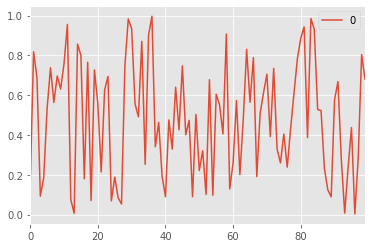

In [17]:
pd_temp.plot()

Now we can convert it into Spark DataFrame:

In [18]:
spark_temp = spark.createDataFrame(pd_temp)

`createOrReplaceTempView` creates (or replaces if that view name already exists) a lazily evaluated "view" that you can then use like a table in Spark SQL. 

It does not persist to memory unless you cache (persist) the dataset that underpins the view.

In [19]:
spark_temp.createOrReplaceTempView("temp")

The created view is `TEMPORARY` which means it is not persistent.

In [20]:
print(spark.catalog.listTables())

[Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


In [21]:
spark_temp.show()

+--------------------+
|                   0|
+--------------------+
| 0.14856841431155443|
|  0.8178463071833407|
|  0.6890066503057222|
| 0.09190390598126819|
| 0.18616801378978454|
|  0.5328308854535329|
|  0.7376701168828318|
|  0.5635210574497913|
|  0.6962628921036629|
|  0.6305075761666319|
|  0.7580509019791073|
|  0.9553239815331708|
| 0.07459173901223548|
|0.006329728911324994|
|  0.8562405146186816|
|  0.7996594897634322|
| 0.17965872748804013|
|   0.765306873728706|
| 0.07026446516918583|
|  0.7266593696549868|
+--------------------+
only showing top 20 rows



We can now use transformations on this DataFrame. The transformations are translated (compiled) to RDD transformations.

In [22]:
from pyspark.sql.functions import col, asc

In [23]:
spark_temp.filter((col('0') > 0.9)).show()

+------------------+
|                 0|
+------------------+
|0.9553239815331708|
|0.9828679627820956|
|0.9341238007805328|
|0.9027074720281189|
|0.9966508361314558|
| 0.906822720554549|
|0.9431506459628034|
|0.9851738718029206|
|0.9310769354789425|
+------------------+



## Creating Spark Data Frames from input files

In [25]:
file_path = "data/airports-2.csv"

# Read in the airports data
airports = spark.read.csv(file_path,header=True)

# Show the data
print(airports.show())

+---+--------------------+------------------+----------------+---+----+------------------+-------------------+----+---+---+--------------------+-------+-----------+
|  1|      Goroka Airport|            Goroka|Papua New Guinea|GKA|AYGA|-6.081689834590001|      145.391998291|5282| 10|  U|Pacific/Port_Moresby|airport|OurAirports|
+---+--------------------+------------------+----------------+---+----+------------------+-------------------+----+---+---+--------------------+-------+-----------+
|  2|      Madang Airport|            Madang|Papua New Guinea|MAG|AYMD|    -5.20707988739|      145.789001465|  20| 10|  U|Pacific/Port_Moresby|airport|OurAirports|
|  3|Mount Hagen Kagam...|       Mount Hagen|Papua New Guinea|HGU|AYMH|-5.826789855957031| 144.29600524902344|5388| 10|  U|Pacific/Port_Moresby|airport|OurAirports|
|  4|      Nadzab Airport|            Nadzab|Papua New Guinea|LAE|AYNZ|         -6.569803|         146.725977| 239| 10|  U|Pacific/Port_Moresby|airport|OurAirports|
|  5|Port 

In [28]:
airports.printSchema()

root
 |-- Airport ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- IATA: string (nullable = true)
 |-- ICAO: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Altitude: integer (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- DST: string (nullable = true)
 |-- Tz database time zone: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Source: string (nullable = true)



In [26]:
# Read in the airports data
airports = spark.read.csv(file_path, header=False)

headers = ["Airport ID", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude", 
              "Altitude", "Timezone", "DST", "Tz database time zone", "Type", "Source"]

# Create a new dataframe with column names manually (headers are not included)
# * (splat) - converts a list to list of arguments
airports = spark.read.csv(file_path, header=False, inferSchema=True).toDF(*headers)


# Show the data
print(airports.show(5))

+----------+--------------------+------------+----------------+----+----+------------------+------------------+--------+--------+---+---------------------+-------+-----------+
|Airport ID|                Name|        City|         Country|IATA|ICAO|          Latitude|         Longitude|Altitude|Timezone|DST|Tz database time zone|   Type|     Source|
+----------+--------------------+------------+----------------+----+----+------------------+------------------+--------+--------+---+---------------------+-------+-----------+
|         1|      Goroka Airport|      Goroka|Papua New Guinea| GKA|AYGA|-6.081689834590001|     145.391998291|    5282|      10|  U| Pacific/Port_Moresby|airport|OurAirports|
|         2|      Madang Airport|      Madang|Papua New Guinea| MAG|AYMD|    -5.20707988739|     145.789001465|      20|      10|  U| Pacific/Port_Moresby|airport|OurAirports|
|         3|Mount Hagen Kagam...| Mount Hagen|Papua New Guinea| HGU|AYMH|-5.826789855957031|144.29600524902344|    5388|

In [27]:
airports.printSchema()

root
 |-- Airport ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- IATA: string (nullable = true)
 |-- ICAO: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Altitude: integer (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- DST: string (nullable = true)
 |-- Tz database time zone: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Source: string (nullable = true)



It may be useful to convert them to Pandas for quick browsing. 

**Warning!** This is not efficient for large datasets, as it requires performing actions on the dataset.

In [30]:
airports.toPandas()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7179,12053,Rugao Air Base,Rugao,China,RUG,ZSRG,32.257885,120.501656,0,\N,\N,\N,airport,OurAirports
7180,12054,Wuhu Air Base,Wuhu,China,WHU,ZSWU,31.390600,118.408997,0,\N,\N,\N,airport,OurAirports
7181,12055,Shanshan Airport,Shanshan,China,SXJ,ZWSS,42.911701,90.247498,0,\N,\N,\N,airport,OurAirports
7182,12056,Yingkou Lanqi Airport,Yingkou,China,YKH,ZYYK,40.542524,122.358600,0,\N,\N,\N,airport,OurAirports


### Running SQL queries on dataframes

In [31]:
airports.createOrReplaceTempView("airports")

In [32]:
# Get the first 10 rows of flights
query = "FROM airports SELECT * LIMIT 10"

airports10 = spark.sql(query)

# Show the results
airports10.show()

+----------+--------------------+------------+----------------+----+----+------------------+------------------+--------+--------+---+---------------------+-------+-----------+
|Airport ID|                Name|        City|         Country|IATA|ICAO|          Latitude|         Longitude|Altitude|Timezone|DST|Tz database time zone|   Type|     Source|
+----------+--------------------+------------+----------------+----+----+------------------+------------------+--------+--------+---+---------------------+-------+-----------+
|         1|      Goroka Airport|      Goroka|Papua New Guinea| GKA|AYGA|-6.081689834590001|     145.391998291|    5282|      10|  U| Pacific/Port_Moresby|airport|OurAirports|
|         2|      Madang Airport|      Madang|Papua New Guinea| MAG|AYMD|    -5.20707988739|     145.789001465|      20|      10|  U| Pacific/Port_Moresby|airport|OurAirports|
|         3|Mount Hagen Kagam...| Mount Hagen|Papua New Guinea| HGU|AYMH|-5.826789855957031|144.29600524902344|    5388|

### More complex examples 

Read data from CSV file:
 * `inferSchema` - to detect which columns are numbers (not strigs!) - useful e.g. for sorting.
 * `header` - to read the firs line as column names

In [33]:
countries = spark.read.csv("data/countries of the world.csv",inferSchema=True,header=True)

In [34]:
countries.toPandas()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,None,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",None,None,NaN,None,None,"0,02",0,"99,98",1,None,None,None,None,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


We can inspect the schema of the DataFrame.

In [35]:
countries.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Population: integer (nullable = true)
 |-- Area (sq. mi.): integer (nullable = true)
 |-- Pop. Density (per sq. mi.): string (nullable = true)
 |-- Coastline (coast/area ratio): string (nullable = true)
 |-- Net migration: string (nullable = true)
 |-- Infant mortality (per 1000 births): string (nullable = true)
 |-- GDP ($ per capita): integer (nullable = true)
 |-- Literacy (%): string (nullable = true)
 |-- Phones (per 1000): string (nullable = true)
 |-- Arable (%): string (nullable = true)
 |-- Crops (%): string (nullable = true)
 |-- Other (%): string (nullable = true)
 |-- Climate: string (nullable = true)
 |-- Birthrate: string (nullable = true)
 |-- Deathrate: string (nullable = true)
 |-- Agriculture: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Service: string (nullable = true)



### Examples of SQL Queries

In [36]:
countries.createOrReplaceTempView("countries")

In [37]:
spark.sql("SELECT * FROM countries WHERE Region LIKE '%OCEANIA%'").toPandas()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
1,Australia,OCEANIA,20264082,7686850,"2,6","0,34","3,98","4,69",29000,"100,0","565,5","6,55","0,04","93,41",1,"12,14","7,51","0,038","0,262","0,7"
2,Cook Islands,OCEANIA,21388,240,"89,1","50,00",None,None,5000,"95,0","289,9","17,39","13,04","69,57",2,21,None,"0,151","0,096","0,753"
3,Fiji,OCEANIA,905949,18270,"49,6","6,18","-3,14","12,62",5800,"93,7","112,6","10,95","4,65","84,4",2,"22,55","5,65","0,089","0,135","0,776"
4,French Polynesia,OCEANIA,274578,4167,"65,9","60,60","2,94","8,44",17500,"98,0","194,5","0,82","5,46","93,72",2,"16,68","4,69","0,031","0,19","0,769"
5,Guam,OCEANIA,171019,541,"316,1","23,20",0,"6,94",21000,"99,0","492,0","9,09","16,36","74,55",2,"18,79","4,48",None,None,None
6,Kiribati,OCEANIA,105432,811,"130,0","140,94",0,"48,52",800,None,"42,7","2,74","50,68","46,58",2,"30,65","8,26","0,089","0,242","0,668"
7,Marshall Islands,OCEANIA,60422,11854,"5,1","3,12","-6,04","29,45",1600,"93,7","91,2","16,67","38,89","44,44",2,"33,05","4,78","0,317","0,149","0,534"
8,"Micronesia, Fed. St.",OCEANIA,108004,702,"153,9","870,66","-20,99","30,21",2000,"89,0","114,8","5,71","45,71","48,58",2,"24,68","4,75","0,289","0,152","0,559"
9,Nauru,OCEANIA,13287,21,"632,7","142,86",0,"9,95",5000,None,"143,0",0,0,100,2,"24,76","6,7",None,None,None


### Queries using PySpark DSL

DSL = Domain Specific Language - API similar to natural or other language, implemented as library in another language.

List all the countries with the population > 38 million

In [38]:
countries.filter((col("Population") > 38000000)).orderBy("Population").toPandas()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Poland,EASTERN EUROPE,38536869,312685,"123,3","0,16","-0,49","8,51",11100,"99,8","306,3","45,91","1,12","52,97",3,"9,85","9,89","0,05","0,311","0,64"
1,Argentina,LATIN AMER. & CARIB,39921833,2766890,"14,4","0,18","0,61","15,18",11200,"97,1","220,4","12,31","0,48","87,21",3,"16,73","7,55","0,095","0,358","0,547"
2,Spain,WESTERN EUROPE,40397842,504782,"80,0","0,98","0,99","4,42",22000,"97,9","453,5","26,07","9,87","64,06",3,"10,06","9,72","0,04","0,295","0,665"
3,Sudan,SUB-SAHARAN AFRICA,41236378,2505810,"16,5","0,03","-0,02","62,5",1900,"61,1","16,3","6,83","0,18","92,99",2,"34,53","8,97","0,387","0,203","0,41"
4,Colombia,LATIN AMER. & CARIB,43593035,1138910,"38,3","0,28","-0,31","20,97",6300,"92,5","176,2","2,42","1,67","95,91",2,"20,48","5,58","0,125","0,342","0,533"
5,South Africa,SUB-SAHARAN AFRICA,44187637,1219912,"36,2","0,23","-0,29","61,81",10700,"86,4","107,0","12,08","0,79","87,13",1,"18,2",22,"0,025","0,303","0,671"
6,Ukraine,C.W. OF IND. STATES,46710816,603700,"77,4","0,46","-0,39","20,34",5400,"99,7","259,9","56,21","1,61","42,18",3,"8,82","14,39","0,187","0,452","0,361"
7,Burma,ASIA (EX. NEAR EAST),47382633,678500,"69,8","0,28","-1,8","67,24",1800,"85,3","10,1","15,19","0,97","83,84",2,"17,91","9,83","0,564","0,082","0,353"
8,"Korea, South",ASIA (EX. NEAR EAST),48846823,98480,"496,0","2,45",0,"7,05",17800,"97,9","486,1","17,18","1,95","80,87",3,10,"5,85","0,033","0,403","0,563"
9,Italy,WESTERN EUROPE,58133509,301230,"193,0","2,52","2,07","5,94",26700,"98,6","430,9","27,79","9,53","62,68",None,"8,72","10,4","0,021","0,291","0,688"


Select all the countries from Europe

In [39]:
countries.select("Country", "Population").where(col("Region").like("%EUROPE%")).show()

+--------------------+----------+
|             Country|Population|
+--------------------+----------+
|            Albania |   3581655|
|            Andorra |     71201|
|            Austria |   8192880|
|            Belgium |  10379067|
|Bosnia & Herzegov...|   4498976|
|           Bulgaria |   7385367|
|            Croatia |   4494749|
|     Czech Republic |  10235455|
|            Denmark |   5450661|
|      Faroe Islands |     47246|
|            Finland |   5231372|
|             France |  60876136|
|            Germany |  82422299|
|          Gibraltar |     27928|
|             Greece |  10688058|
|           Guernsey |     65409|
|            Hungary |   9981334|
|            Iceland |    299388|
|            Ireland |   4062235|
|        Isle of Man |     75441|
+--------------------+----------+
only showing top 20 rows



Conditions in `where` clause can contain logical expressions.

In [40]:
countries.select("Country", "Population")\
.where((col("Region").like("%EUROPE%")) & (col("Population")> 10000000)).show()

+---------------+----------+
|        Country|Population|
+---------------+----------+
|       Belgium |  10379067|
|Czech Republic |  10235455|
|        France |  60876136|
|       Germany |  82422299|
|        Greece |  10688058|
|         Italy |  58133509|
|   Netherlands |  16491461|
|        Poland |  38536869|
|      Portugal |  10605870|
|       Romania |  22303552|
|         Spain |  40397842|
|United Kingdom |  60609153|
+---------------+----------+



### Aggregation

We can run aggregations with predefined functions (faster!):

In [41]:
from pyspark.sql.functions import sum

In [42]:
pd_countries = countries.select("Region", "Population").groupBy("Region").agg(sum("Population")).toPandas()

In [43]:
pd_countries

,Region,sum(Population)
0,BALTICS,7184974
1,C.W. OF IND. STATES,280081548
2,ASIA (EX. NEAR EAST),3687982236
3,WESTERN EUROPE,396339998
4,NORTHERN AMERICA,331672307
5,NEAR EAST,195068377
6,EASTERN EUROPE,119914717
7,OCEANIA,33131662
8,SUB-SAHARAN AFRICA,749437000
9,NORTHERN AFRICA,161407133


We can make the column name look better, by using `alias`:

In [44]:
pd_countries = countries.select("Region", "Population").groupBy("Region").agg(sum("Population").alias('Total')).toPandas()

In [45]:
pd_countries

,Region,Total
0,BALTICS,7184974
1,C.W. OF IND. STATES,280081548
2,ASIA (EX. NEAR EAST),3687982236
3,WESTERN EUROPE,396339998
4,NORTHERN AMERICA,331672307
5,NEAR EAST,195068377
6,EASTERN EUROPE,119914717
7,OCEANIA,33131662
8,SUB-SAHARAN AFRICA,749437000
9,NORTHERN AFRICA,161407133


### Plot examples 
Pandas DataFrames are useful for plotting using MatPlotLib:

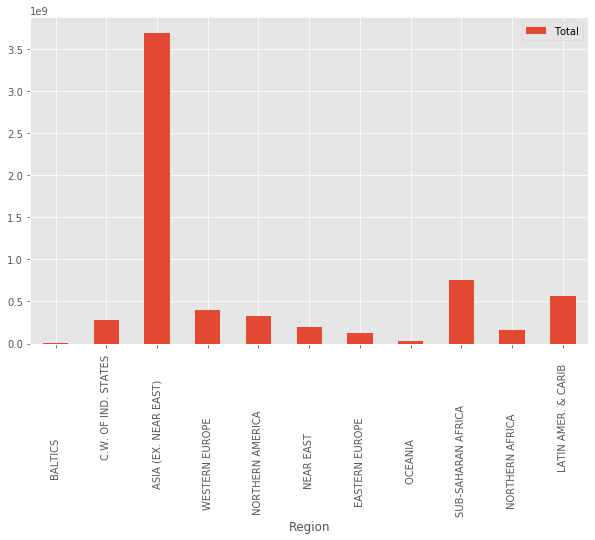

In [46]:
pd_countries.plot(x='Region', y='Total',kind='bar', figsize=(10, 6))

## User defined functions for data manipulation
Our `countries` DataFrame has some problems:
 * missing values
 * some numbers use comma instead of point as floating point separator (e.g. Literacy  = 99,4)
 
We can clean the data using User Defined Functions (UDF)

In [47]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

Define a Python function which coverts numbers with commas to `float`

In [48]:
def to_float (s) :
   return float(s.replace(',','.'))

Test that it works:

In [49]:
to_float('0,99')

0.99

Now define a Spark UDF:

In [50]:
float_udf = udf(to_float , FloatType())

Before we can use the UDF, we need to remove empty rows. Otherwise our UDF will fail.

In [51]:
full_countries = countries.select('Country', 'Population', 'Literacy (%)', 'GDP ($ per capita)').na.drop()

We can now apply the new UDF to the Data Frame:

In [52]:
full_countries = full_countries.withColumn("Literacy", float_udf("Literacy (%)"))

In [53]:
full_countries.show(50)

+--------------------+----------+------------+------------------+--------+
|             Country|Population|Literacy (%)|GDP ($ per capita)|Literacy|
+--------------------+----------+------------+------------------+--------+
|        Afghanistan |  31056997|        36,0|               700|    36.0|
|            Albania |   3581655|        86,5|              4500|    86.5|
|            Algeria |  32930091|        70,0|              6000|    70.0|
|     American Samoa |     57794|        97,0|              8000|    97.0|
|            Andorra |     71201|       100,0|             19000|   100.0|
|             Angola |  12127071|        42,0|              1900|    42.0|
|           Anguilla |     13477|        95,0|              8600|    95.0|
|  Antigua & Barbuda |     69108|        89,0|             11000|    89.0|
|          Argentina |  39921833|        97,1|             11200|    97.1|
|            Armenia |   2976372|        98,6|              3500|    98.6|
|              Aruba |   

In [54]:
full_countries.where((col("Literacy") < 50) & (col("GDP ($ per capita)") > 700)).show()

+--------------+----------+------------+------------------+--------+
|       Country|Population|Literacy (%)|GDP ($ per capita)|Literacy|
+--------------+----------+------------+------------------+--------+
|       Angola |  12127071|        42,0|              1900|    42.0|
|   Bangladesh | 147365352|        43,1|              1900|    43.1|
|        Benin |   7862944|        40,9|              1100|    40.9|
|       Bhutan |   2279723|        42,2|              1300|    42.2|
| Burkina Faso |  13902972|        26,6|              1100|    26.6|
|         Chad |   9944201|        47,5|              1200|    47.5|
|  Gambia, The |   1641564|        40,1|              1700|    40.1|
|       Guinea |   9690222|        35,9|              2100|    35.9|
|Guinea-Bissau |   1442029|        42,4|               800|    42.4|
|         Iraq |  26783383|        40,4|              1500|    40.4|
|         Mali |  11716829|        46,4|               900|    46.4|
|   Mauritania |   3177388|       

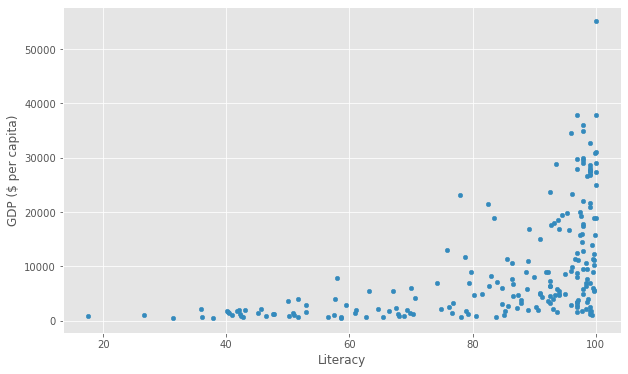

In [55]:
full_countries.toPandas().plot(x="Literacy",y="GDP ($ per capita)",kind="scatter",figsize=(10, 6))

# Exercises

1. Print all the airports that are to the North from Krakow.
1. For each state, find the airport which is closest to the South Pole.
1. Plot the coordinates of all the airports. Bonus: plot on the map.
1. Plot GDP vs. Phones for all countries in Asia.
1. Plot Infant mortality vs. Literacy for top 30 richest and top 30 poorest countries.

# Useful information

 * https://spark.apache.org/docs/latest/quick-start.html
 * https://spark.apache.org/docs/latest/sql-programming-guide.html
 * https://pandas.pydata.org/pandas-docs/stable/visualization.html